**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [4]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab4
configure_lab4()
from lab4 import *
GRADER = part_2()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
--2021-09-03 12:03:34--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14633 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  14.29K  --.-KB/s    in 0.001s  

2021-09-03 12:03:34 (22.7 MB/s) - ‘general.py’ saved [14633/14633]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 4 - Parte 2. Regularización de modelos.

En este laboratorio vamos analizar el efecto del sobre-ajuste (*over-fitting*), como identificarlo y como podemos regualizar los modelos para evitarlo o disminuir su efecto. 

En este laboratorio, vamos a enfocarnos en 2 modelos (usando libreria de sklearn): 

1. Regresión logistica 
2. MLP

**No vamos enfocar en como tratar la maldición de la dimensionalidad** ya que esto lo vamos a ver un poco más adelante cuando evaluemos las tecnicas de selección de caracteristicas.

Vamos usar [el dataset de digitos escritos a mano](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) para realizar nuestra practica.

In [5]:
x,y = load_digits(return_X_y=True)

Una de las condiciones para que se presente sobre-ajustes es tener un conjunto de entrenamiento pequeño. 

En nuestra practica vamos a simular esta condición para ver que tecnicas podemos usar para reducir el efecto del sobre-ajuste. 

**Nota**
1. En un problema real, si se observa que las medidas de rendimiento no llegan satisfacen las necesidades, la respuesta puede ser que se necesitan más datos en el conjunto de entrenamiento.


In [6]:
# simular conjunto de datos pequeño
x, x_test, y, y_test = train_test_split(
    x, y, test_size=0.6, random_state=10)
scaler = StandardScaler().fit(x)
x = scaler.transform(x)
x_test = scaler.transform(x_test)

### Ejercicio 1 - Detectar sobre ajuste

En nuestro primer ejercicio vamos a crear una función para detectar las diferencias entre los errores de entrenamiento y de prueba.
1. calcular error de entrenamiento y prueba
2. la función recibe de manera arbitraria un estimador de sklearn
3. [usar accuracy score como medida de rendimiento](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score)
4. Se debe retornar la diferencia absoluta (solo numeros positivos) entre entrenamiento y prueba.

In [7]:
# ejercicio de código
def diff_train_test(sklearnModel, Xtrain, Ytrain, Xtest, Ytest):
    """función que retorna error de entrenamiento
    sklearnModel: objeto estimador de sklearn ya entrenado
    X: matriz numpy con las caracteristicas
    Y: vector de numpy con las etiquetas
    
    retorna: tuple con tres elementos:
        error entrenamiento, error test y 
        diff absoluta entre error y test
    """
    error_train = accuracy_score(y_true =Ytrain , y_pred = sklearnModel.predict(Xtrain ) )
    error_test = accuracy_score(y_true= Ytest , y_pred = sklearnModel.predict(Xtest ))
    diff =  error_train - error_test
    return (error_train, error_test, diff)
        

In [8]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio1", diff_train_test)

TEST EXITOSO!


Con la función construida, vamos a usarla para verificar la differencia entre el error de entrenamiento y prueba para los dos modelos que vamos a usar:
1. MLP con dos capas, cada una con 64 neuornas. `random_state=1` es usado para lograr tener los mismos resultados siempre
2. [Regresión logistica forzada para que no use ninguna regularización](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression). `random_state=1` es usado para lograr tener los mismos resultados

In [9]:
mlp = MLPClassifier(hidden_layer_sizes=[20,20], max_iter=500, alpha =1e-6, random_state=1)
mlp.fit(x, y)
# aca usamos el * para pasa cada elemento como argumento 
print("MLP entrenamiento:{0:.3f}, test:{1:.3f} y diff {2:.3f}".format(*diff_train_test(mlp,x,y, x_test, y_test)))

MLP entrenamiento:1.000, test:0.943 y diff 0.057


In [10]:
reg = LogisticRegression(penalty='none', max_iter=500,  random_state=1)
reg.fit(x, y)
print("Logistic Regresion entrenamiento:{0:.3f}, test:{1:.3f} y diff {2:.3f}".format(*diff_train_test(reg,x,y, x_test, y_test)))

Logistic Regresion entrenamiento:1.000, test:0.930 y diff 0.070


### Ejercicio 2 - Experimentar con MLP regularizado

Vamos a comenzar regularizar el modelo, el primer metodo que vamos a usar es el de parada anticipada (*early-stopping*). Este ya se encuentra implementado dentro de la libreria, vamos a experimentar con este parametro y el numero de neuronas en el MLP.

In [11]:
#@title Pregunta Abierta
#@markdown ¿Explique en sus palabras a que corresponde el metodo de parada anticipada?
respuesta_1 = "El m\xE9todo de parada anticipada es una estrategia que se usa para evitar el sobreajuste en el que se detiene el entrenamiento cuando el error de validaci\xF3n est\xE1 aumentando ." #@param {type:"string"}

In [12]:
#@title Pregunta Abierta
#@markdown ¿basandose en la documentación de sklearn para MLPClassifier que relación tiene el parametro validation_fraction con la parada anticipada?
respuesta_2 = "Es la parte de los datos de entrenamiento que se reservan como conjunto de validaci\xF3n para la parada anticipada, depende del valor de early_stopping (true)." #@param {type:"string"}

In [13]:
# ejercicio de código
def exp_mlp_early_stop(Xtrain,Xtest,Ytrain, Ytest, num_neurons, is_early_stop):
    """ función para realizar experimentos con el MLP con early stopping
    Xtrain: matriz de numpy con caracteristicas de entrenamiento
    Xtest: matriz de numpy con caracteristicas de prueba
    ytrain: vector numpy con etiqueta de entrenamiento
    ytest: vector numpy con etiqueta de prueba
    num_neurons: list de enteros con el numero de neuronas a usar
    is_early_stop: list de boolean para confirmar si se aplica early stop
    
    Retorna: dataframe con 5 columnas:
        - numero de neuronas
        - error de entrenamiento
        - error de prueba
        - diferencia entrenamiento y prueba  
    """
    resultados = pd.DataFrame()
    idx = 0
    for early_stop in is_early_stop:
        for neurons in num_neurons:
            #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
            # prestar atención a los parametros, correctos.
            hidden_layer_sizes = tuple(2*[neurons])
            # llame el parametro que el MLP pare anticipadamente
            mlp = MLPClassifier(hidden_layer_sizes= hidden_layer_sizes, max_iter = 1000,random_state=1, early_stopping= early_stop )
            # entrenar
            mlp.fit(X=Xtrain, y=Ytrain)
            # llamar la funcion creada anteriomente
            error_train, error_test, diff = diff_train_test(mlp, Xtrain, Ytrain, Xtest, Ytest)

            resultados.loc[idx,'neuronas en capas ocultas'] = neurons 
            resultados.loc[idx,'error de entrenamiento'] = error_train
            resultados.loc[idx,'error de prueba'] = error_test
            resultados.loc[idx,'diferencia entrenamiento y prueba'] = diff
            resultados.loc[idx,'is_early_stop'] = early_stop
            idx+=1
    return (resultados)

In [14]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio2", exp_mlp_early_stop)

TEST EXITOSO!


In [15]:
res_early_stop = exp_mlp_early_stop(x, x_test, y, y_test, [8,16,20,24], [True, False])

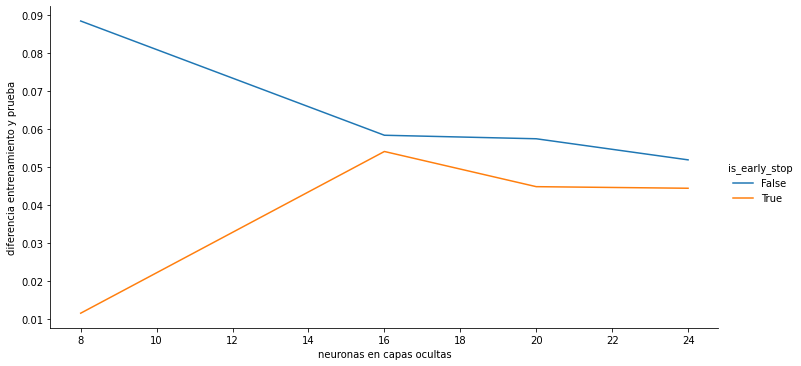

In [16]:
import seaborn as sns
sns.relplot(x = 'neuronas en capas ocultas', y='diferencia entrenamiento y prueba', hue = 'is_early_stop', data = res_early_stop, kind = 'line', aspect=2)

Ahora vamos a experimentar con el parametro L2 del MLP.

In [17]:
#@title Pregunta Abierta
#@markdown ¿explique en sus palabras en qué consiste la regularización L2?
respuesta_3 = "\"La regularizacion en general ayuda a penalizar los pesos de las variables que est\\xE1n muy correlacionadas o poco correlacionadas, d\\xE1ndoles un peso mayor o menor dependiendo de que tan correlacionadas esten, de una manera parecida trabaja la Regularizacion L2 ya que si se piensa que los atributos de entrada estan altamente correlacionados se aplica esta regularizacion para hacer que los coeficientes sean mucho mas peque\\xF1os esto genera que la correlaci\\xF3n que exist\\xEDa inicialmente disminuya lo que ayuda a que el modelo  logre generalizar de una mejor manera y evitar posibles sobre-ajustes.\"" #@param {type:"string"}

In [18]:
# ejercicio de código
def exp_mlp_l2(Xtrain,Xtest,Ytrain, Ytest, num_neurons, l2_values):
    """ función para realizar experimentos con el MLP con early stopping
    Xtrain: matriz de numpy con caracteristicas de entrenamiento
    Xtest: matriz de numpy con caracteristicas de prueba
    ytrain: vector numpy con etiqueta de entrenamiento
    ytest: vector numpy con etiqueta de prueba
    num_neurons: list de enteros con el numero de neuronas a usar
    l2: list de floats con valores para regularizacion l2
    
    Retorna: dataframe con 5 columnas:
        - numero de neuronas
        - error de entrenamiento
        - error de prueba
        - diferencia entrenamiento y prueba  
    """
    resultados = pd.DataFrame()
    idx = 0
    for l2 in l2_values:
        for neurons in num_neurons:
            #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
            # prestar atención a los parametros, correctos.
            hidden_layer_sizes = tuple(2*[neurons])
            # llame el parametro adecuado del MLPClassifier
            mlp = MLPClassifier(hidden_layer_sizes= hidden_layer_sizes, max_iter = 1000, random_state=1, alpha=l2)
            mlp.fit(X=Xtrain, y=Ytrain)
            # llamar la funcion creada anteriomente
            error_train, error_test, diff = diff_train_test(mlp, Xtrain, Ytrain, Xtest, Ytest)
            resultados.loc[idx,'neuronas en capas ocultas'] = neurons 
            resultados.loc[idx,'error de entrenamiento'] = error_train
            resultados.loc[idx,'error de prueba'] = error_test
            resultados.loc[idx,'diferencia entrenamiento y prueba'] = diff
            resultados.loc[idx,'l2'] = l2
            idx+=1
    return (resultados)

In [19]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio3", exp_mlp_l2)

TEST EXITOSO!


In [20]:
res_l2 = exp_mlp_l2(x, x_test, y, y_test, [8,16,20,24], [1e-6,1e-3,1e-1,1e0, 1e1])

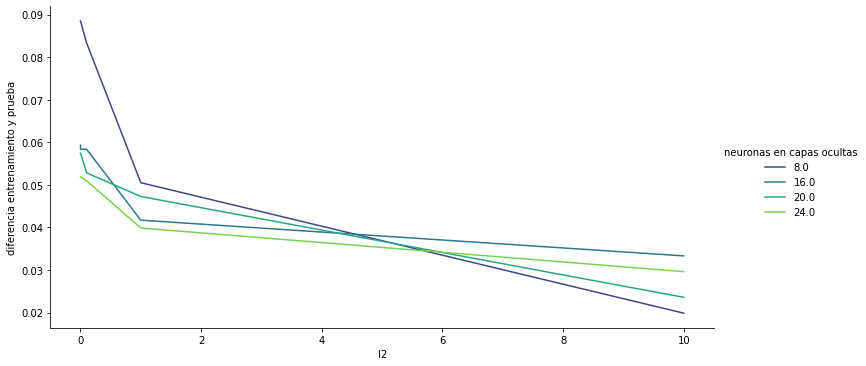

In [21]:
sns.relplot(x = 'l2', y='diferencia entrenamiento y prueba',
            hue = 'neuronas en capas ocultas', 
            data = res_l2, kind = 'line', 
            aspect=2, palette=sns.color_palette('viridis', n_colors=res_l2['neuronas en capas ocultas'].nunique()))

In [22]:
#@title Pregunta Abierta
#@markdown ¿qué efecto tiene el L2 en el overfitting/sobre-ajuste? explique
respuesta_4 = "En la L2  se combate el sobreajuste forzando a que los pesos sean mas peque\xF1os, pero sin hacerlos 0 como ocurre en la L1, generando as\xED que las entradas menos correlacionadas o menos significativas tengan pesos mas peque\xF1os \xF3sea que afecten en menor medida al modelo" #@param {type:"string"}

### Ejercicio 3 - Experimentar con regresión logistica regularizada

Ahora vamos explorar la opciones de regularización de la regresión logistica. En la libreria se implementan más formas de regularizar, pero solo vamos a comprobar la regularización de norma L2.

In [23]:
# ejercicio de código
def exp_reg_l2(Xtrain,Xtest,Ytrain, Ytest, l2_values):
    """ función para realizar experimentos con el MLP con early stopping
    Xtrain: matriz de numpy con caracteristicas de entrenamiento
    Xtest: matriz de numpy con caracteristicas de prueba
    ytrain: vector numpy con etiqueta de entrenamiento
    ytest: vector numpy con etiqueta de prueba
    l2: list de floats con valores para regularizacion l2
    
    Retorna: dataframe con 5 columnas:
        - numero de neuronas
        - error de entrenamiento
        - error de prueba
        - diferencia entrenamiento y prueba  
    """
    resultados = pd.DataFrame()
    idx = 0
    for l2 in l2_values:
        #Haga el llamado a la función para crear y entrenar el modelo usando los datos de entrenamiento
        # prestar atención a los parametros, correctos., para lograr
        # la regularizacion deseada (pasar el valor de "l2" directamente al parametro de la libreria asociado)
        reg = LogisticRegression(max_iter = 500, random_state=1, C=l2)
        reg.fit(X=Xtrain, y=Ytrain)
        # llamar la funcion creada anteriomente
        error_train, error_test, diff = diff_train_test(reg, Xtrain, Ytrain, Xtest, Ytest)
        resultados.loc[idx,'error de entrenamiento'] = error_train
        resultados.loc[idx,'error de prueba'] = error_test
        resultados.loc[idx,'diferencia entrenamiento y prueba'] = diff
        resultados.loc[idx,'l2'] = l2
        idx+=1
    return (resultados)

In [24]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio4", exp_reg_l2)

TEST EXITOSO!


In [25]:
reg_l2 = exp_reg_l2(x, x_test, y, y_test, [1e-6,1e-3,1e-1,1e0, 1e1])

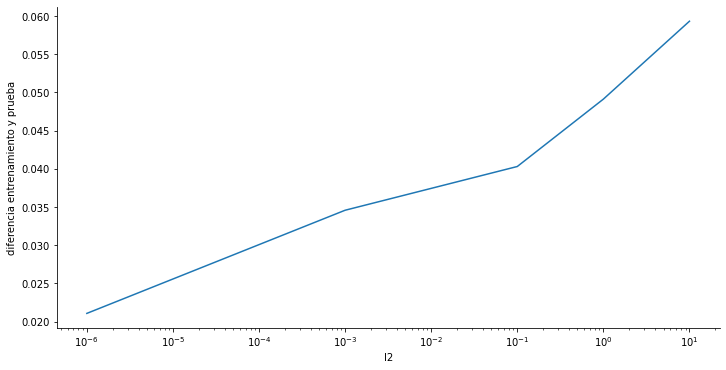

In [26]:
g = sns.relplot(x = 'l2', y='diferencia entrenamiento y prueba',
               data = reg_l2, kind = 'line', 
                aspect=2)

g.set(xscale="log")

In [28]:
#@title Pregunta Abierta
#@markdown ¿qué efecto tiene el parametro que controla L2 en la regresión logistica en el overfitting? es diferente al MLP?
respuesta_5 = "Consultando la documentaci\xF3n se puede observar que el par\xE1metro C se define como los inverso de los pesos de regularizaci\xF3n.  Claramente es diferente al MLP ya que si nos vamos a revisar la teor\xEDa del MLP se puede ver que en el C no se cambia nada, mientras que aqu\xED el C se define como el inverso. Esta diferencia tambi\xE9n se puede apreciar en las graficas donde en MLP para valores peque\xF1os se espera un decrecimiento en la grafica mientras que aqu\xED se espera un crecimiento al ser C el inverso, ya que para valores peque\xF1os en el divisor arroja resultados grandes." #@param {type:"string"}

### Ejercicio 4 Efecto del tamaño del conjunto de entrenamiento

Finalmente como mencionamos anteriormente, en los ejercicios que hemos resuelto, estabamos simulando la situación de un conjunto de datos de entrenamiento pequeño. En nuestro ultimo ejercicio vamos comprobar el efecto del tamaño del conjunto de entrenamiento.

In [29]:
# ejercicio de codigo
def train_size_experiments(sk_estimator, train_pcts,X,Y):
    """funcion que realiza experimentos para
        comprobar la influencia del tamaño de conjunto
        de entrenamiento.
    
    sk_estimator: estimador/modelo de sklearn definido (sin entrenar)
    train_pcts: lista de floats con los pct de entrenamiento a evaluar
    X: matriz de numpy del conjunto de caracteristicas
    Y: vector numpy con las etiquetas
    
    Retorna: dataframe con 5 columnas:
        - tamaño del conjunto de entrenamiento (porcentaje!)
        - error de entrenamiento
        - error de prueba
        - diferencia entrenamiento y prueba 
    """
    resultados = pd.DataFrame()
    idx = 0
    for train_pct in train_pcts:
        #complete el con train_pct
        # preste atencion a que parametro usar!
        # recuerde que son porcentajes
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, random_state=10, train_size = train_pct )
        # normalizamos
        scaler = StandardScaler().fit(Xtrain)
        Xtrain = scaler.transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        # entrenar!
        sk_estimator.fit(X=Xtrain, y=Ytrain)
        # llamar la funcion creada anteriomente
        error_train, error_test, diff = diff_train_test(sk_estimator, Xtrain, Ytrain, Xtest, Ytest)
        resultados.loc[idx,'error de entrenamiento'] = error_train
        resultados.loc[idx,'error de prueba'] = error_test
        resultados.loc[idx,'diferencia entrenamiento y prueba'] = diff
        # complete con el tamaño del entrenamiento
        resultados.loc[idx,'tamaño de entrenamiento'] = Xtrain.shape[0]
        idx+=1
    
    return (resultados)
    

In [30]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio5", train_size_experiments)

TEST EXITOSO!


In [31]:
# debemos recargar nuestro conjunto de datos
x,y = load_digits(return_X_y=True)

In [32]:
# vamos a usar con un MLP
mlp = MLPClassifier(hidden_layer_sizes=[20,20], max_iter=500, random_state=1)
train_size_exp = train_size_experiments(mlp, [0.2,0.3,0.5,0.7,0.9], x, y)

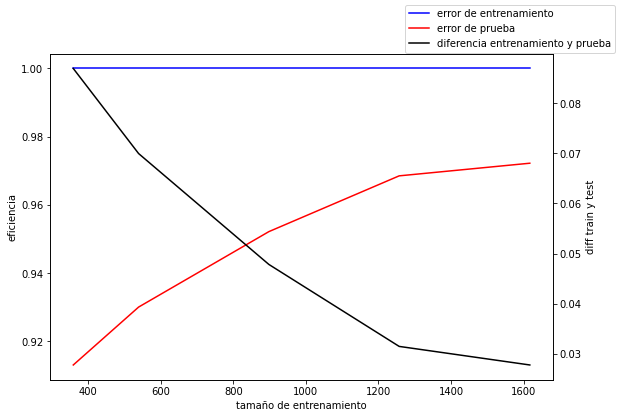

In [33]:
# vemos las tres medidas
ax = train_size_exp.plot(x="tamaño de entrenamiento", y="error de entrenamiento", color="b", legend=False, figsize = (9,6))
train_size_exp.plot(x="tamaño de entrenamiento", y="error de prueba",  ax=ax, legend=False, color="r")
ax2 = ax.twinx()
ax2.set_ylabel("diff train y test")
ax.set_ylabel("eficiencia")
train_size_exp.plot(x="tamaño de entrenamiento", y="diferencia entrenamiento y prueba", ax=ax2, legend=False, color="k")
ax.figure.legend(loc = 'best')
plt.show()

**Notas Finales ** 

Para tener en cuenta: [Sklearn hay una libreria que realiza algo similar a lo que creamos en el anterior ejercicio.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.learning_curve.html)

Debemos notar que en esta practica exageramos algunas situaciones para lograr medir y ver el efecto del sobre-ajuste. En la practica un flujo de trabajo mas ideal es el siguiente:

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" alt="grid_search_workflow" width="500"/>


1. dividimos el conjunto al inicio, reservando un conjunto de test. 
2. verificamos los mejores parametros mediante validación cruzada. 
3. reentrenamos con los mejores parametros y realizamos la evaluación final. 
4. En esta última etapa es donde validamos si existe sobre ajuste. Si existe, se deben incluir parametros para mitigar el sobre ajuste en la validación cruzada y volver al paso 2.

In [34]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia le archivo al formulario ¡buen trabajo!


In [35]:
#@title Integrantes
codigo_integrante_1 ='1000415078' #@param {type:"string"}
codigo_integrante_2 = '1035833769'  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [ ]:
GRADER.grade()